## Model Training on DAPI channel

44 images coupled with their ground truths for the training on the DAPI channel, to segment nuclei from microscopy images.
StarDist pretrained model segmented with some incorrection, this is an attempt to train our own model in order to increase the precision of the segmentation.


In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()


/home/isabella.osei/miniconda3/envs/fijistard/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  after removing the cwd from sys.path.


Load images and corresponding ground truth labelled.

In [7]:
X= sorted(glob('/home/isabella.osei/Projects/For training/*.tif'))
Y= sorted(glob('/home/isabella.osei/Projects/Masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [8]:
X= list(map(imread, X))
Y= list(map(imread,Y))

Visualize one example image

In [4]:

for i in range(len(X)):
    img,lbl= X[i],fill_label_holes(Y[i])

assert img.ndim in (2,3)
img= img if img.ndim==2 else img[...,:3]

Text(0.5, 1.0, 'GT labels')

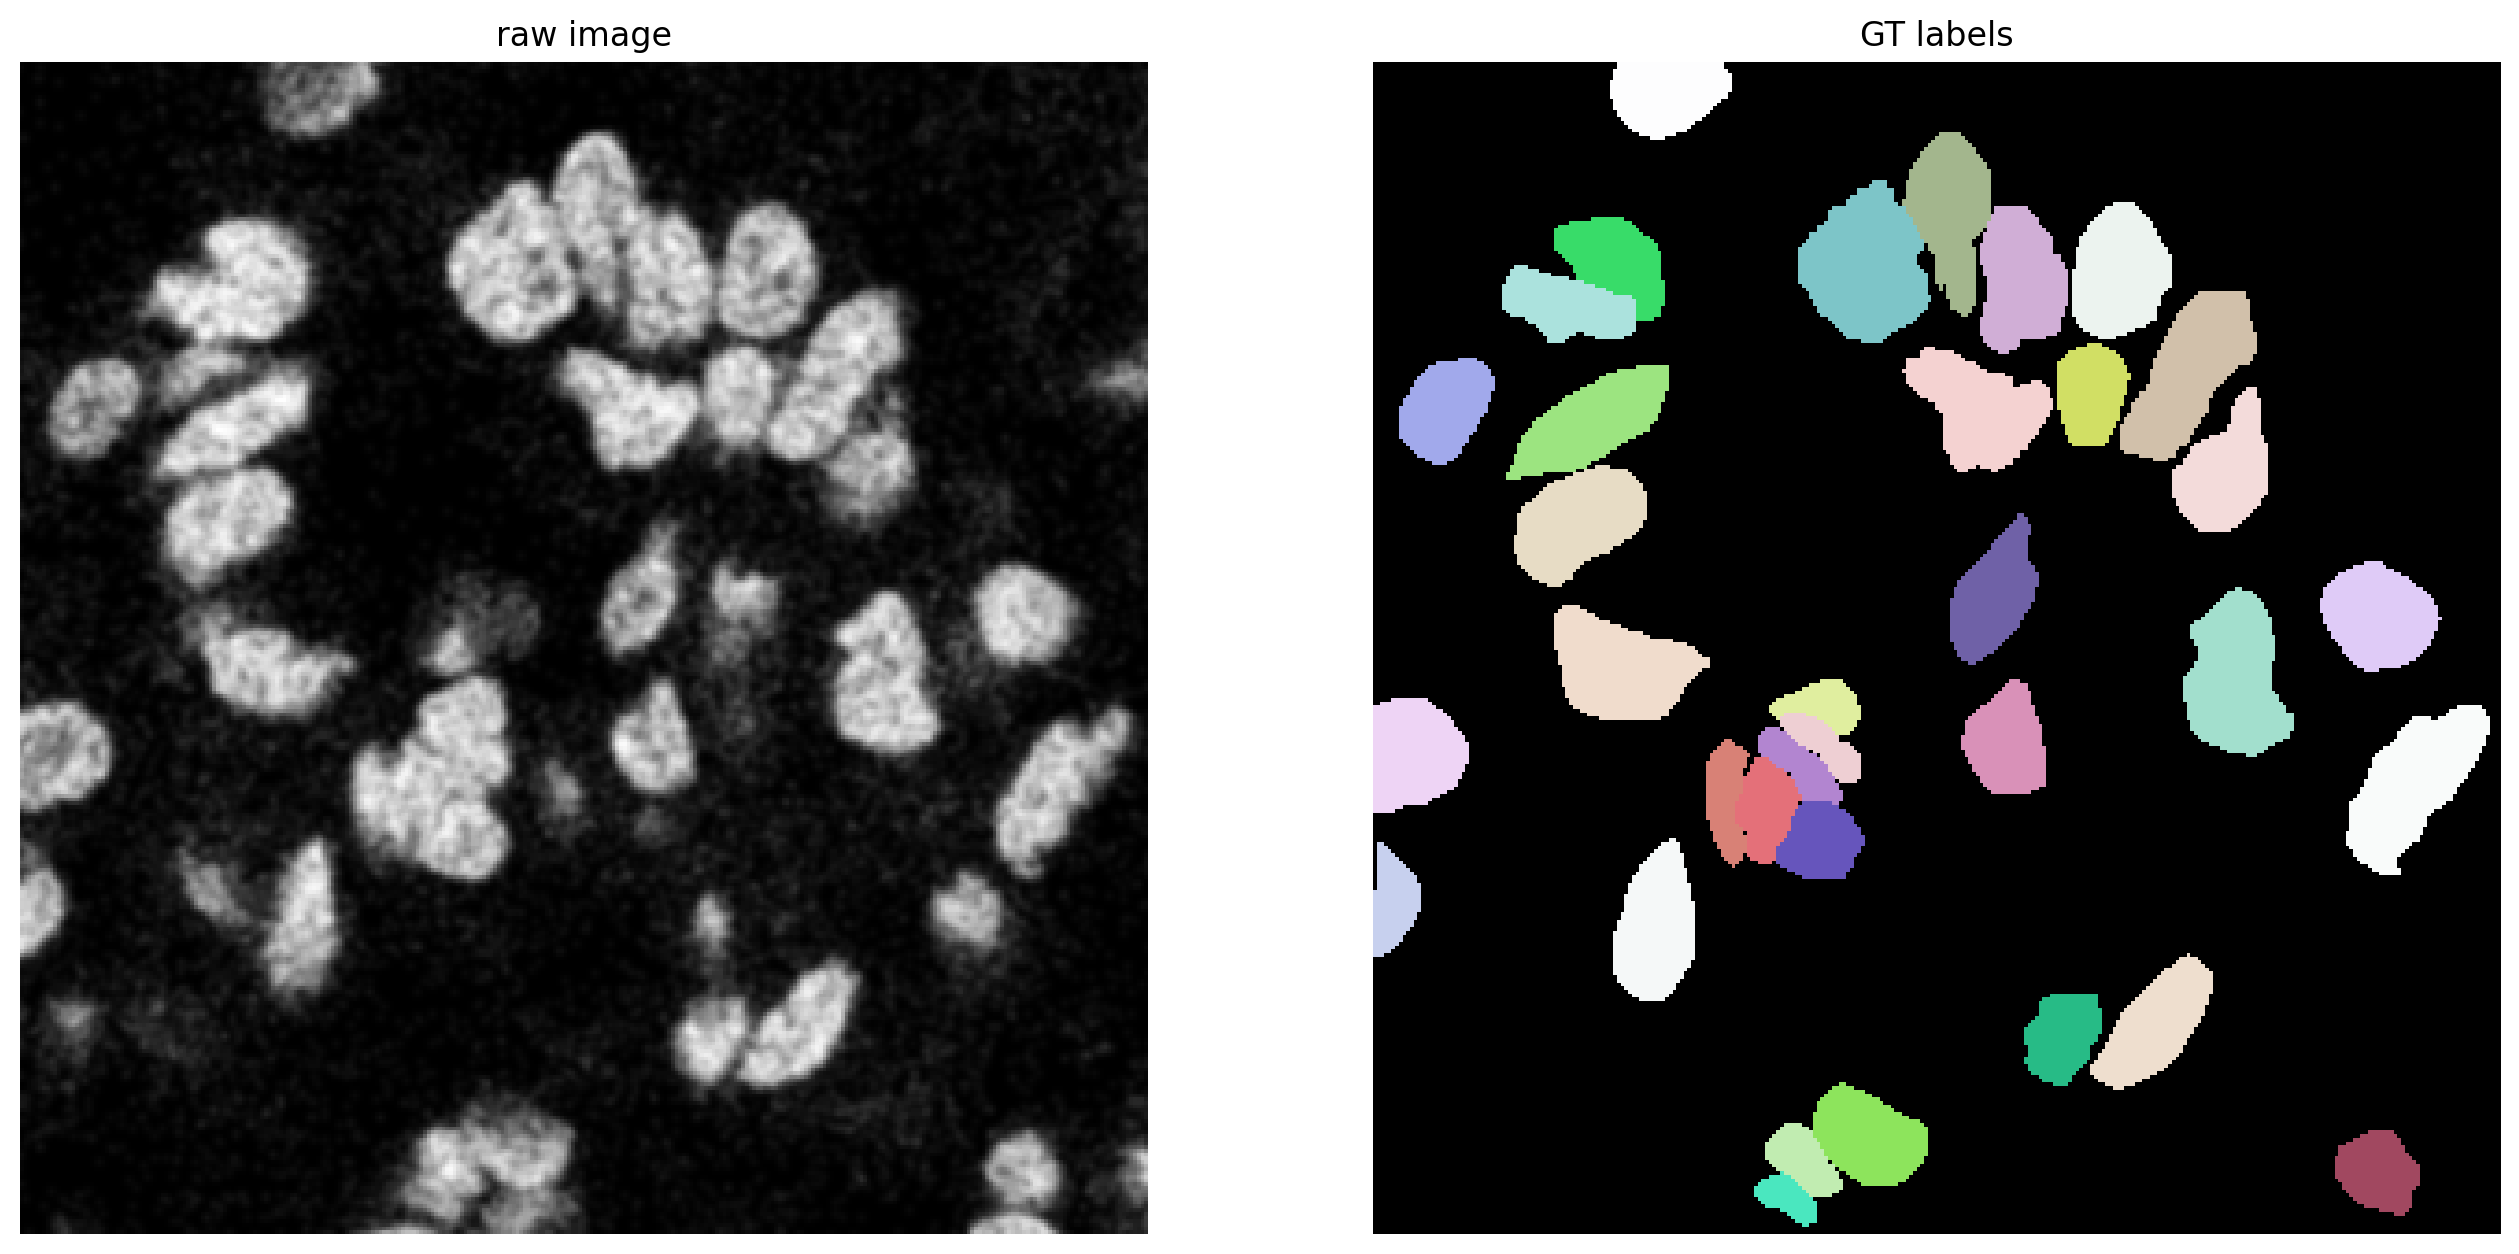

In [5]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray'); plt.axis("off"); plt.title("raw image")
plt.subplot(122); plt.imshow(lbl,cmap= lbl_cmap); plt.axis("off"); plt.title("GT labels")

## Training the model

In [3]:
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D


Using TensorFlow backend.


Normalize images and fill small label holes

In [15]:
n_channel=1 if X[0].ndim==2 else X[0].shape[-1]
axis_norm=(0,1)
if n_channel > 1:
    print("normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()
    
X= [normalize(x, 1,99.8, axis= axis_norm) for x in tqdm(X)]
Y= [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 43/43 [00:00<00:00, 140.19it/s]


Split data into train and validation datasets.

In [16]:
assert len(X) > 1 ,"not enough training data"
rng = np.random.RandomState(42)
ind= rng.permutation(len(X))
n_val= max(1, int(round(0.15 * len(ind))))
ind_train,ind_val= ind[:-n_val], ind[-n_val:]
X_val,Y_val= [X[i] for i in ind_val] , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]
print("Num of images: {}".format(len(X)))
print("- training: {}".format(len(X_trn)))
print("- validation: {}".format(len(X_val)))


Num of images: 43
- training: 37
- validation: 6


In [17]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

In [18]:
use_gpu= False and gputools_available()
conf= Config2D(n_rays= 32,
              grid= (2,2),
              use_gpu= use_gpu,
              n_channel_in= n_channel,
              )
vars(conf)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [19]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(0.8)

In [12]:
model= StarDist2D(conf, name= 'stardist', basedir= 'models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



base_model.py (149): output path for model already exists, files may be overwritten: /home/isabella.osei/Projects/models/stardist


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.640825, nms_thresh=0.4.


In [20]:
median_size= calculate_extents(list(Y), np.median)
fov= np.array(model._axes_tile_overlap('YX'))
print(f"median object size: {median_size}")
print(f"network field of view: {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network")

median object size: [49. 57.]
network field of view: [94 94]


### Data augmentation 

Augmenter implemented to apply random rotations, flips and intensity changes peculiar for 2D microscopy images.

In [21]:
def random_fliprot(img,mask):
    assert img.ndim >= mask.ndim
    axes= tuple(range(mask.ndim))
    perm= tuple(np.random.permutation(axes))
    img= img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask= mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img= np.flip(img, axis= ax)
            mask= np.flip(mask,axis=ax)
    return img,mask


def random_intensity_change(img):
    img= img*np.random.uniform(0.6,2)+ np.random.uniform(-0.2,0.2)
    return img



In [22]:
def augmenter(x,y):
    
    """Augmentation of raw image and corresponding labelled ground truth image"""
    
    x,y = random_fliprot(x,y)
    x= random_intensity_change(x)
    
    #add some gaussian noise
    
    sig= 0.02*np.random.uniform(0,1)
    x= x + sig*np.random.normal(0,1,x.shape)
    return x,y

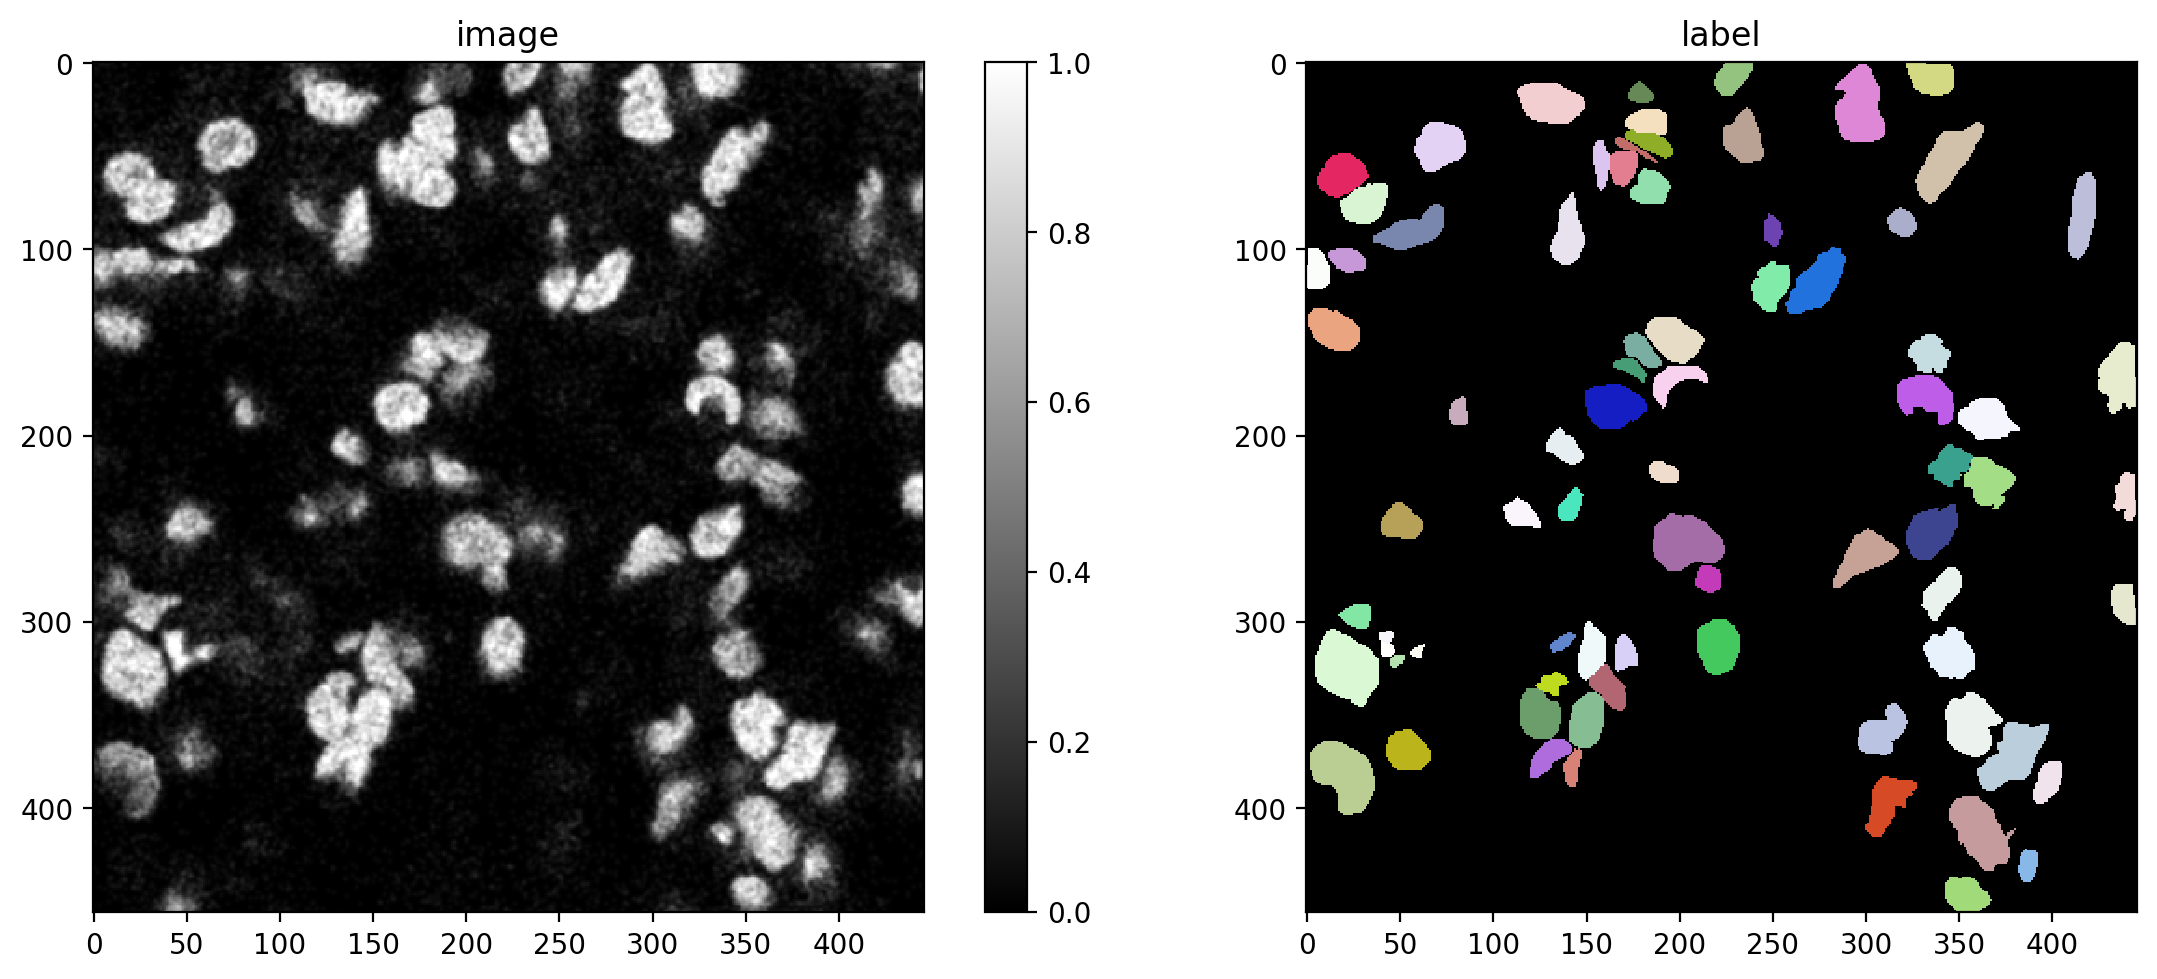

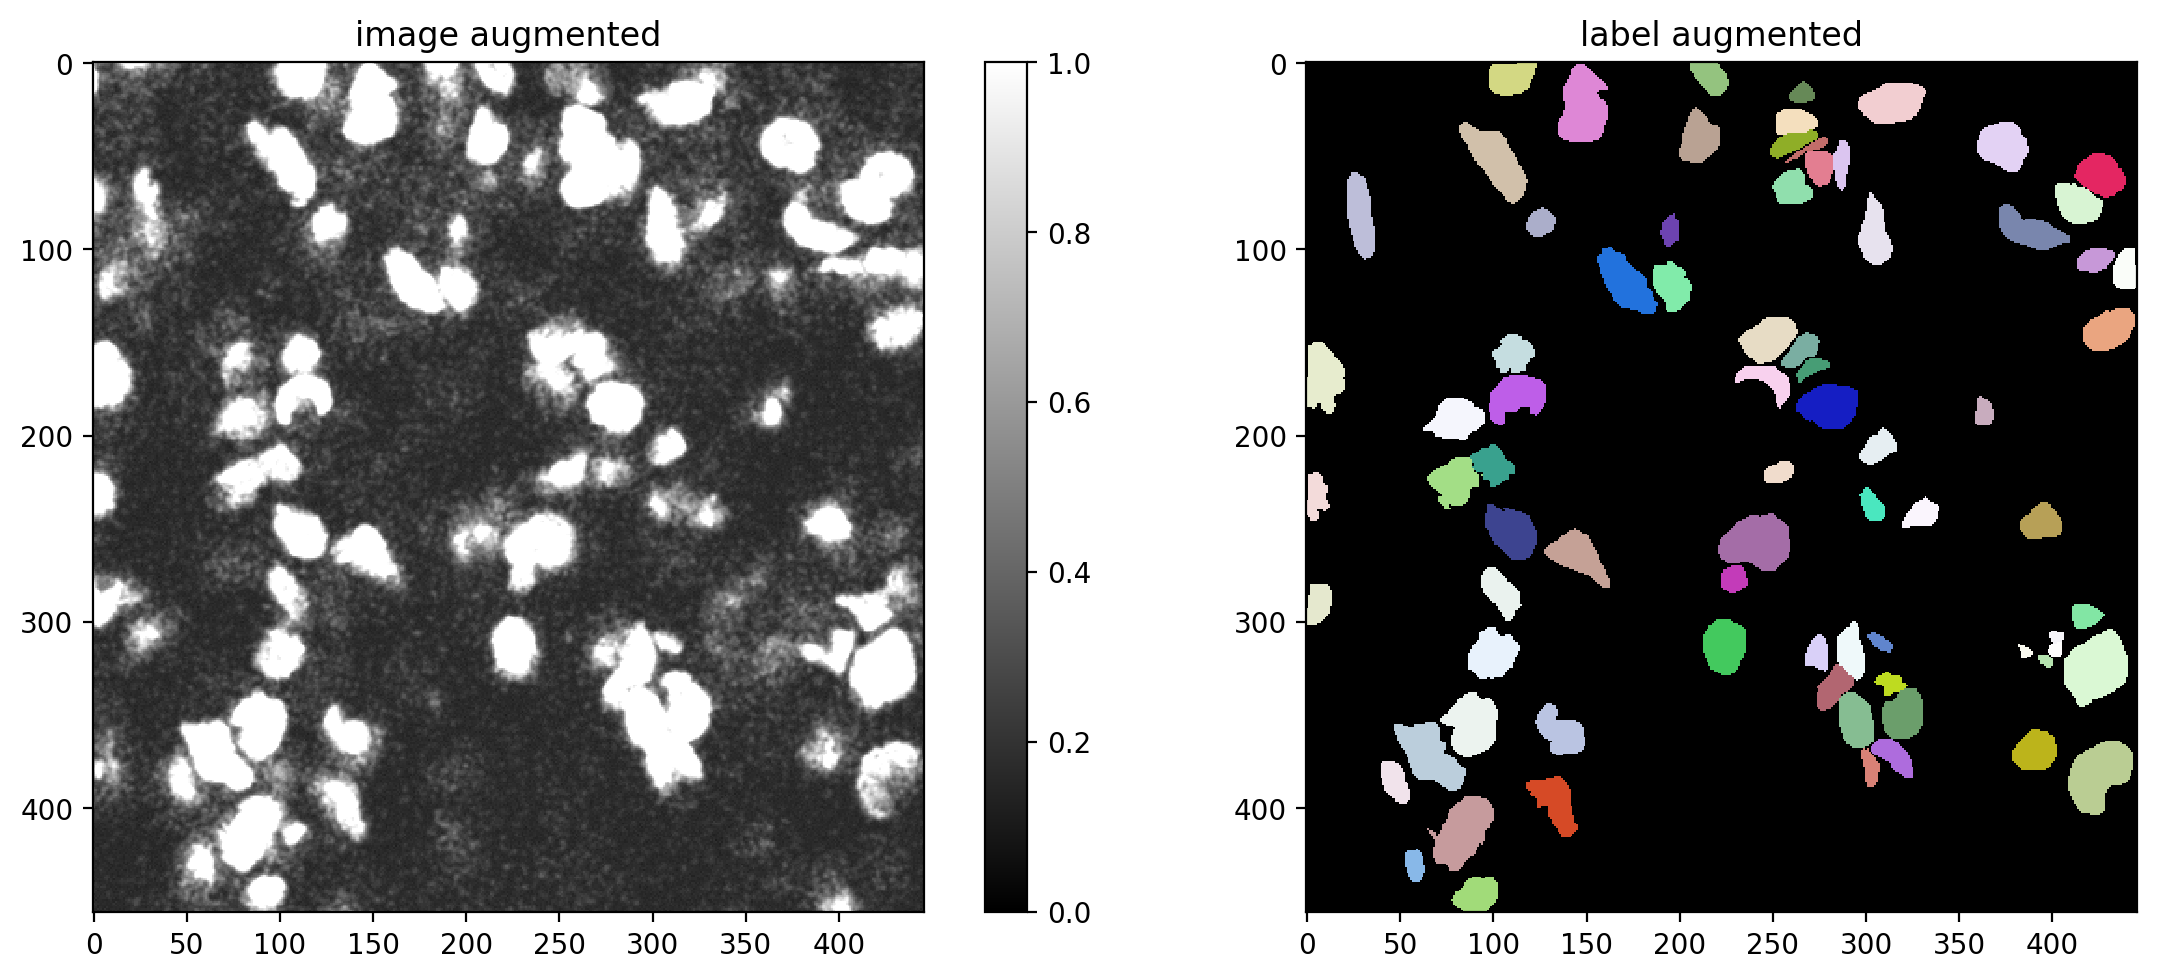

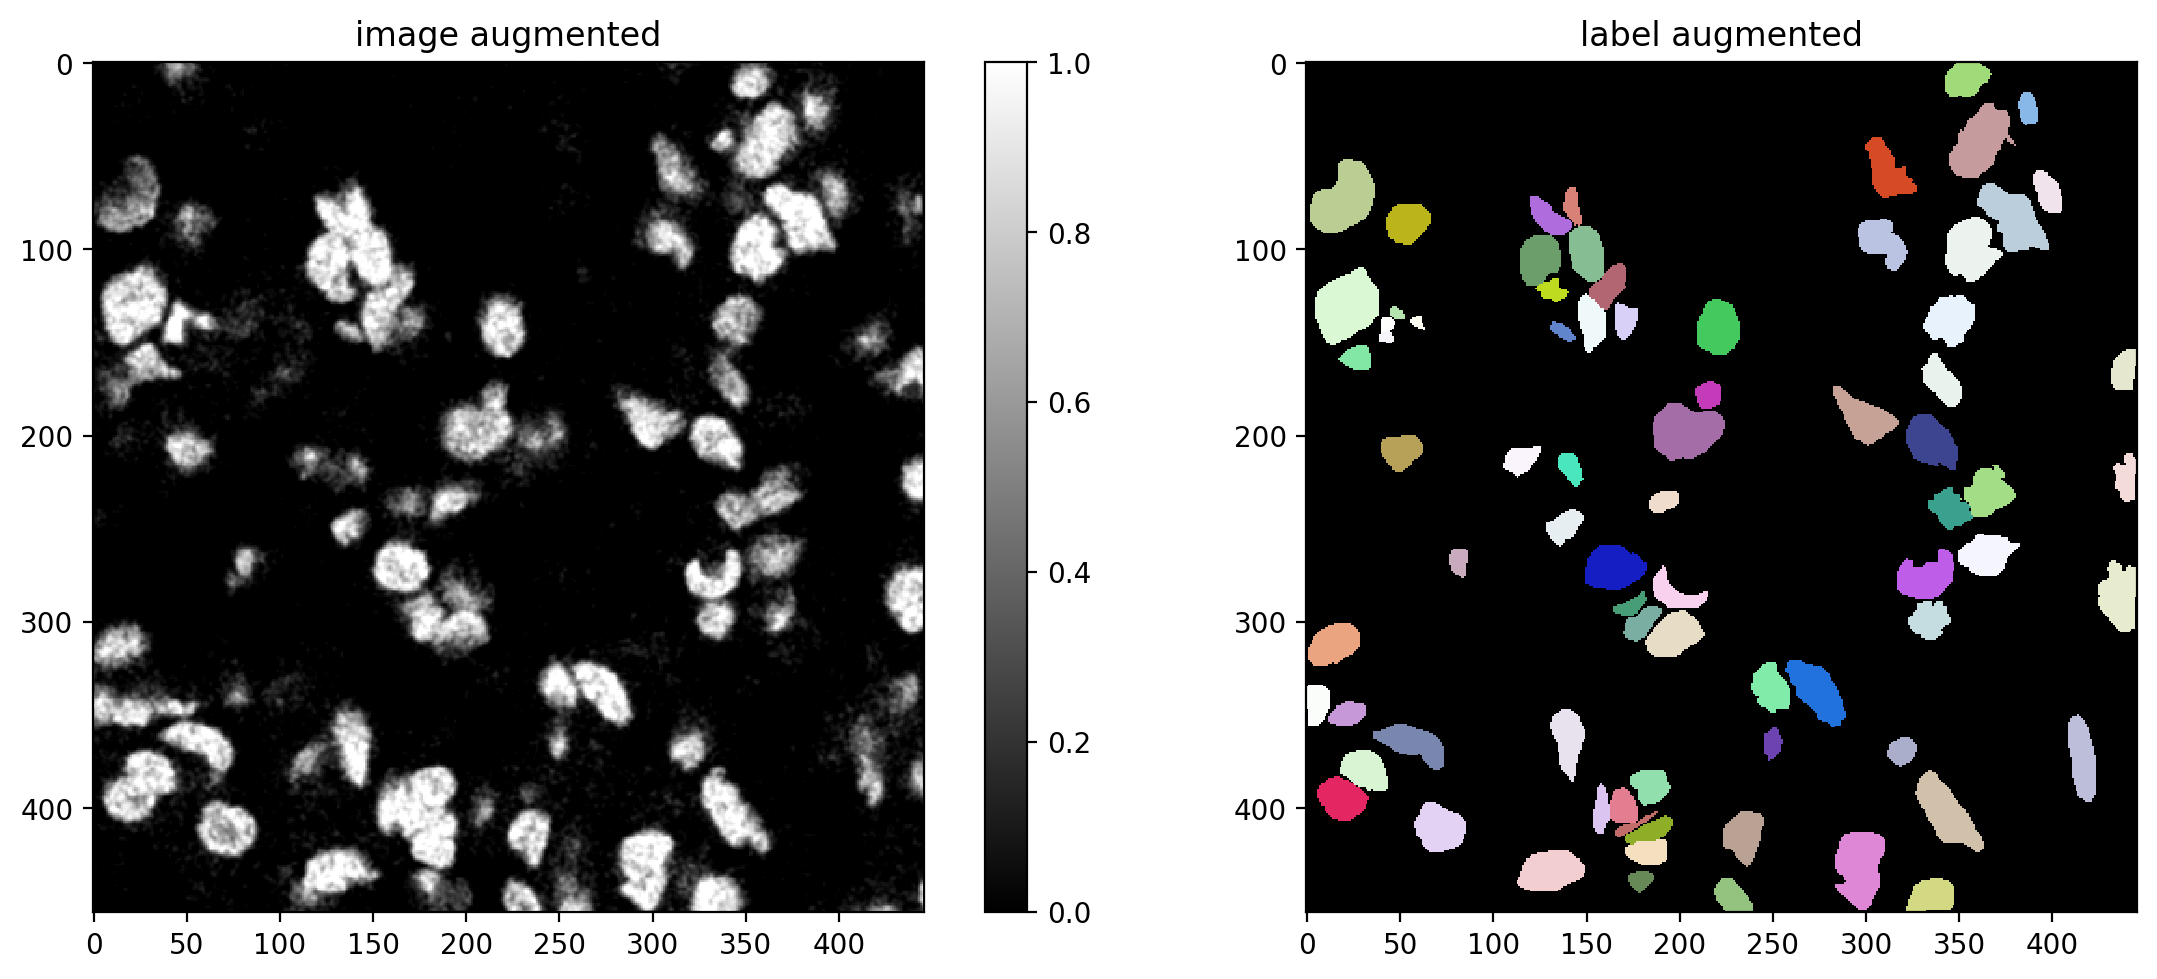

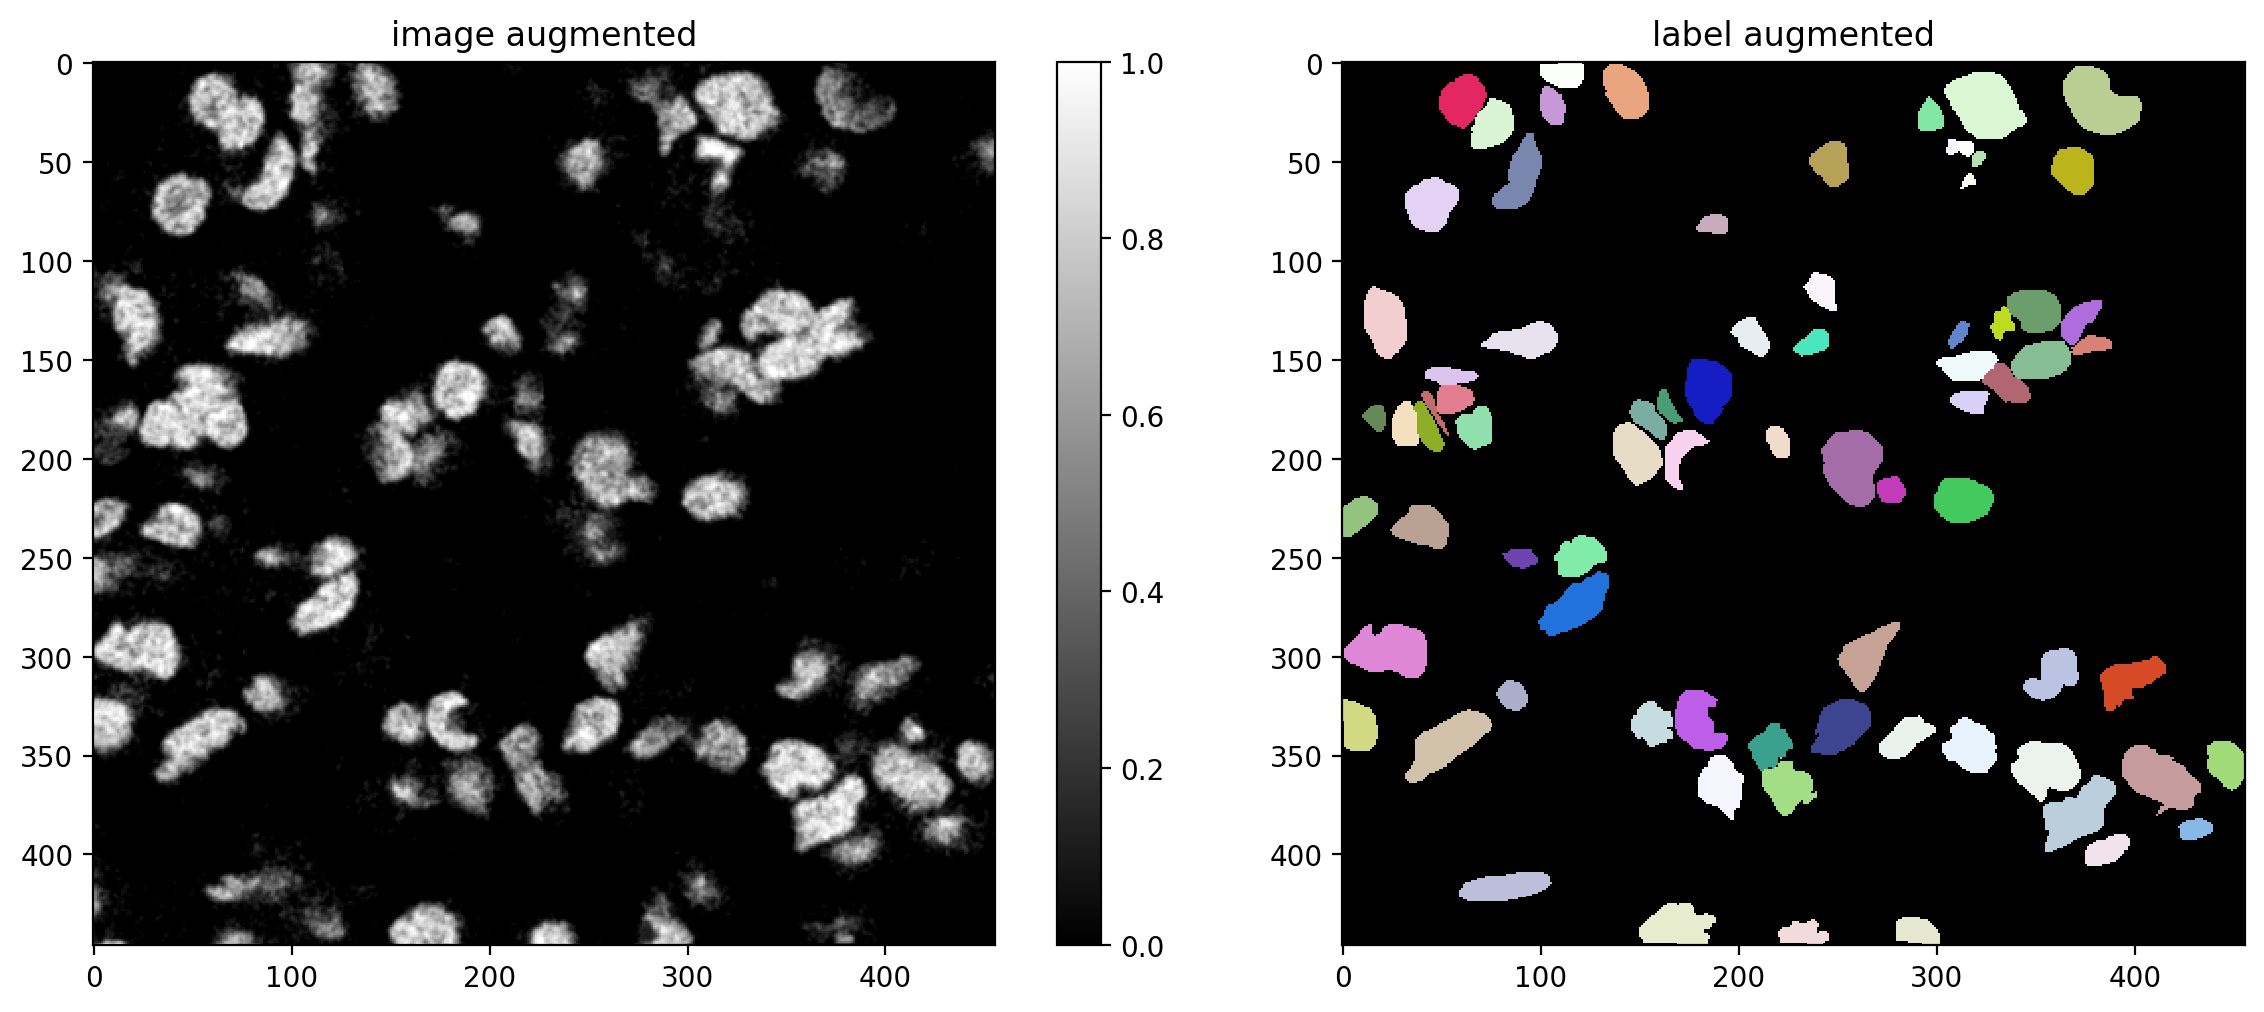

In [23]:
img,lbl = X[0],Y[0]
plot_img_label(img,lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title= "image augmented", lbl_title="label augmented")

### Training

In [18]:
quick_demo= False
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)


Epoch 1/400
100/100 [==============================] - 64s 641ms/step - loss: 2.4702 - prob_loss: 0.4056 - dist_loss: 10.3229 - prob_kld: 0.2493 - dist_relevant_mae: 10.3214 - dist_relevant_mse: 208.6506 - dist_dist_iou_metric: 0.3561 - val_loss: 2.4512 - val_prob_loss: 0.4685 - val_dist_loss: 9.6921 - val_prob_kld: 0.2926 - val_dist_relevant_mae: 9.9880 - val_dist_relevant_mse: 207.5343 - val_dist_dist_iou_metric: 0.3475
Epoch 2/400
100/100 [==============================] - 64s 642ms/step - loss: 2.0089 - prob_loss: 0.3744 - dist_loss: 8.1723 - prob_kld: 0.2196 - dist_relevant_mae: 8.1709 - dist_relevant_mse: 146.0711 - dist_dist_iou_metric: 0.4390 - val_loss: 1.7941 - val_prob_loss: 0.3061 - val_dist_loss: 7.5320 - val_prob_kld: 0.1296 - val_dist_relevant_mae: 7.5172 - val_dist_relevant_mse: 122.1617 - val_dist_dist_iou_metric: 0.5079
Epoch 3/400
100/100 [==============================] - 64s 640ms/step - loss: 1.6194 - prob_loss: 0.2536 - dist_loss: 6.8288 - prob_kld: 0.0959 - dist

100/100 [==============================] - 64s 640ms/step - loss: 0.8143 - prob_loss: 0.1857 - dist_loss: 3.1426 - prob_kld: 0.0298 - dist_relevant_mae: 3.1416 - dist_relevant_mse: 33.6003 - dist_dist_iou_metric: 0.7417 - val_loss: 0.9650 - val_prob_loss: 0.2135 - val_dist_loss: 3.8929 - val_prob_kld: 0.0358 - val_dist_relevant_mae: 3.8413 - val_dist_relevant_mse: 58.9101 - val_dist_dist_iou_metric: 0.7068
Epoch 40/400
100/100 [==============================] - 62s 620ms/step - loss: 0.8296 - prob_loss: 0.1901 - dist_loss: 3.1971 - prob_kld: 0.0330 - dist_relevant_mae: 3.1962 - dist_relevant_mse: 34.5413 - dist_dist_iou_metric: 0.7397 - val_loss: 0.9622 - val_prob_loss: 0.2099 - val_dist_loss: 3.9069 - val_prob_kld: 0.0311 - val_dist_relevant_mae: 3.8506 - val_dist_relevant_mse: 58.0101 - val_dist_dist_iou_metric: 0.7029
Epoch 41/400
100/100 [==============================] - 62s 622ms/step - loss: 0.8599 - prob_loss: 0.2002 - dist_loss: 3.2988 - prob_kld: 0.0384 - dist_relevant_mae: 3

100/100 [==============================] - 62s 620ms/step - loss: 0.7129 - prob_loss: 0.1827 - dist_loss: 2.6508 - prob_kld: 0.0251 - dist_relevant_mae: 2.6499 - dist_relevant_mse: 23.5123 - dist_dist_iou_metric: 0.7794 - val_loss: 1.0033 - val_prob_loss: 0.2158 - val_dist_loss: 4.0865 - val_prob_kld: 0.0365 - val_dist_relevant_mae: 4.0294 - val_dist_relevant_mse: 68.7640 - val_dist_dist_iou_metric: 0.7122
Epoch 78/400
100/100 [==============================] - 62s 625ms/step - loss: 0.8489 - prob_loss: 0.1943 - dist_loss: 3.2727 - prob_kld: 0.0359 - dist_relevant_mae: 3.2714 - dist_relevant_mse: 51.6807 - dist_dist_iou_metric: 0.7515 - val_loss: 0.8921 - val_prob_loss: 0.2140 - val_dist_loss: 3.6089 - val_prob_kld: 0.0340 - val_dist_relevant_mae: 3.4852 - val_dist_relevant_mse: 46.5169 - val_dist_dist_iou_metric: 0.7373
Epoch 79/400
100/100 [==============================] - 65s 654ms/step - loss: 0.7365 - prob_loss: 0.1847 - dist_loss: 2.7593 - prob_kld: 0.0276 - dist_relevant_mae: 2

100/100 [==============================] - 67s 668ms/step - loss: 0.6516 - prob_loss: 0.1776 - dist_loss: 2.3701 - prob_kld: 0.0211 - dist_relevant_mae: 2.3693 - dist_relevant_mse: 18.6318 - dist_dist_iou_metric: 0.7978 - val_loss: 0.9189 - val_prob_loss: 0.2177 - val_dist_loss: 3.6901 - val_prob_kld: 0.0362 - val_dist_relevant_mae: 3.6086 - val_dist_relevant_mse: 64.0643 - val_dist_dist_iou_metric: 0.7371
Epoch 116/400
100/100 [==============================] - 66s 664ms/step - loss: 0.6145 - prob_loss: 0.1770 - dist_loss: 2.1875 - prob_kld: 0.0211 - dist_relevant_mae: 2.1867 - dist_relevant_mse: 15.4248 - dist_dist_iou_metric: 0.8065 - val_loss: 0.9015 - val_prob_loss: 0.2186 - val_dist_loss: 3.5826 - val_prob_kld: 0.0370 - val_dist_relevant_mae: 3.5182 - val_dist_relevant_mse: 61.4173 - val_dist_dist_iou_metric: 0.7454
Epoch 117/400
100/100 [==============================] - 66s 664ms/step - loss: 0.6091 - prob_loss: 0.1773 - dist_loss: 2.1588 - prob_kld: 0.0214 - dist_relevant_mae:

100/100 [==============================] - 64s 640ms/step - loss: 0.5674 - prob_loss: 0.1758 - dist_loss: 1.9577 - prob_kld: 0.0189 - dist_relevant_mae: 1.9570 - dist_relevant_mse: 12.1855 - dist_dist_iou_metric: 0.8244 - val_loss: 0.8811 - val_prob_loss: 0.2177 - val_dist_loss: 3.5254 - val_prob_kld: 0.0359 - val_dist_relevant_mae: 3.4213 - val_dist_relevant_mse: 62.8014 - val_dist_dist_iou_metric: 0.7550
Epoch 154/400
100/100 [==============================] - 64s 639ms/step - loss: 0.5586 - prob_loss: 0.1740 - dist_loss: 1.9231 - prob_kld: 0.0182 - dist_relevant_mae: 1.9224 - dist_relevant_mse: 12.2329 - dist_dist_iou_metric: 0.8282 - val_loss: 0.8785 - val_prob_loss: 0.2179 - val_dist_loss: 3.4873 - val_prob_kld: 0.0370 - val_dist_relevant_mae: 3.4029 - val_dist_relevant_mse: 64.5604 - val_dist_dist_iou_metric: 0.7571
Epoch 155/400
100/100 [==============================] - 64s 640ms/step - loss: 0.5661 - prob_loss: 0.1741 - dist_loss: 1.9598 - prob_kld: 0.0187 - dist_relevant_mae:

100/100 [==============================] - 64s 640ms/step - loss: 0.5394 - prob_loss: 0.1705 - dist_loss: 1.8448 - prob_kld: 0.0173 - dist_relevant_mae: 1.8441 - dist_relevant_mse: 11.3304 - dist_dist_iou_metric: 0.8335 - val_loss: 0.8937 - val_prob_loss: 0.2272 - val_dist_loss: 3.6207 - val_prob_kld: 0.0423 - val_dist_relevant_mae: 3.4525 - val_dist_relevant_mse: 65.0442 - val_dist_dist_iou_metric: 0.7584
Epoch 192/400
100/100 [==============================] - 64s 642ms/step - loss: 0.5683 - prob_loss: 0.1795 - dist_loss: 1.9440 - prob_kld: 0.0208 - dist_relevant_mae: 1.9433 - dist_relevant_mse: 13.0352 - dist_dist_iou_metric: 0.8306 - val_loss: 0.8883 - val_prob_loss: 0.2222 - val_dist_loss: 3.4704 - val_prob_kld: 0.0401 - val_dist_relevant_mae: 3.4364 - val_dist_relevant_mse: 62.1525 - val_dist_dist_iou_metric: 0.7530
Epoch 193/400
100/100 [==============================] - 64s 640ms/step - loss: 0.5517 - prob_loss: 0.1732 - dist_loss: 1.8924 - prob_kld: 0.0178 - dist_relevant_mae:

100/100 [==============================] - 70s 698ms/step - loss: 0.5299 - prob_loss: 0.1741 - dist_loss: 1.7792 - prob_kld: 0.0172 - dist_relevant_mae: 1.7785 - dist_relevant_mse: 9.9276 - dist_dist_iou_metric: 0.8399 - val_loss: 0.8593 - val_prob_loss: 0.2175 - val_dist_loss: 3.3733 - val_prob_kld: 0.0365 - val_dist_relevant_mae: 3.3089 - val_dist_relevant_mse: 62.2441 - val_dist_dist_iou_metric: 0.7651
Epoch 230/400
100/100 [==============================] - 69s 695ms/step - loss: 0.5527 - prob_loss: 0.1727 - dist_loss: 1.8998 - prob_kld: 0.0171 - dist_relevant_mae: 1.8992 - dist_relevant_mse: 12.7488 - dist_dist_iou_metric: 0.8362 - val_loss: 0.8635 - val_prob_loss: 0.2176 - val_dist_loss: 3.4330 - val_prob_kld: 0.0350 - val_dist_relevant_mae: 3.3378 - val_dist_relevant_mse: 62.1543 - val_dist_dist_iou_metric: 0.7642
Epoch 231/400
100/100 [==============================] - 70s 697ms/step - loss: 0.5233 - prob_loss: 0.1739 - dist_loss: 1.7473 - prob_kld: 0.0171 - dist_relevant_mae: 

100/100 [==============================] - 71s 710ms/step - loss: 0.5235 - prob_loss: 0.1715 - dist_loss: 1.7597 - prob_kld: 0.0157 - dist_relevant_mae: 1.7590 - dist_relevant_mse: 10.1853 - dist_dist_iou_metric: 0.8440 - val_loss: 0.8864 - val_prob_loss: 0.2264 - val_dist_loss: 3.5368 - val_prob_kld: 0.0428 - val_dist_relevant_mae: 3.4132 - val_dist_relevant_mse: 62.5910 - val_dist_dist_iou_metric: 0.7591
Epoch 268/400
100/100 [==============================] - 71s 708ms/step - loss: 0.5068 - prob_loss: 0.1734 - dist_loss: 1.6667 - prob_kld: 0.0146 - dist_relevant_mae: 1.6660 - dist_relevant_mse: 8.7381 - dist_dist_iou_metric: 0.8501 - val_loss: 0.8751 - val_prob_loss: 0.2258 - val_dist_loss: 3.5035 - val_prob_kld: 0.0409 - val_dist_relevant_mae: 3.3660 - val_dist_relevant_mse: 66.1560 - val_dist_dist_iou_metric: 0.7655
Epoch 269/400
100/100 [==============================] - 70s 701ms/step - loss: 0.5105 - prob_loss: 0.1716 - dist_loss: 1.6942 - prob_kld: 0.0151 - dist_relevant_mae: 

100/100 [==============================] - 66s 663ms/step - loss: 0.4935 - prob_loss: 0.1735 - dist_loss: 1.5997 - prob_kld: 0.0143 - dist_relevant_mae: 1.5990 - dist_relevant_mse: 8.5748 - dist_dist_iou_metric: 0.8576 - val_loss: 0.8729 - val_prob_loss: 0.2182 - val_dist_loss: 3.4795 - val_prob_kld: 0.0368 - val_dist_relevant_mae: 3.3758 - val_dist_relevant_mse: 65.3225 - val_dist_dist_iou_metric: 0.7658
Epoch 306/400
100/100 [==============================] - 66s 664ms/step - loss: 0.4874 - prob_loss: 0.1714 - dist_loss: 1.5802 - prob_kld: 0.0145 - dist_relevant_mae: 1.5796 - dist_relevant_mse: 8.2275 - dist_dist_iou_metric: 0.8557 - val_loss: 0.8804 - val_prob_loss: 0.2212 - val_dist_loss: 3.4846 - val_prob_kld: 0.0389 - val_dist_relevant_mae: 3.4029 - val_dist_relevant_mse: 63.6666 - val_dist_dist_iou_metric: 0.7620
Epoch 307/400
100/100 [==============================] - 66s 662ms/step - loss: 0.4906 - prob_loss: 0.1715 - dist_loss: 1.5952 - prob_kld: 0.0142 - dist_relevant_mae: 1

100/100 [==============================] - 75s 748ms/step - loss: 0.4574 - prob_loss: 0.1671 - dist_loss: 1.4515 - prob_kld: 0.0124 - dist_relevant_mae: 1.4509 - dist_relevant_mse: 6.9375 - dist_dist_iou_metric: 0.8661 - val_loss: 0.8405 - val_prob_loss: 0.2171 - val_dist_loss: 3.2903 - val_prob_kld: 0.0346 - val_dist_relevant_mae: 3.2250 - val_dist_relevant_mse: 59.3313 - val_dist_dist_iou_metric: 0.7740
Epoch 344/400
100/100 [==============================] - 75s 748ms/step - loss: 0.4670 - prob_loss: 0.1707 - dist_loss: 1.4815 - prob_kld: 0.0129 - dist_relevant_mae: 1.4809 - dist_relevant_mse: 7.0301 - dist_dist_iou_metric: 0.8642 - val_loss: 0.8291 - val_prob_loss: 0.2148 - val_dist_loss: 3.1717 - val_prob_kld: 0.0347 - val_dist_relevant_mae: 3.1673 - val_dist_relevant_mse: 56.3581 - val_dist_dist_iou_metric: 0.7740
Epoch 345/400
100/100 [==============================] - 75s 747ms/step - loss: 0.4729 - prob_loss: 0.1716 - dist_loss: 1.5063 - prob_kld: 0.0127 - dist_relevant_mae: 1

100/100 [==============================] - 75s 749ms/step - loss: 0.4459 - prob_loss: 0.1670 - dist_loss: 1.3946 - prob_kld: 0.0118 - dist_relevant_mae: 1.3939 - dist_relevant_mse: 6.4658 - dist_dist_iou_metric: 0.8698 - val_loss: 0.8427 - val_prob_loss: 0.2178 - val_dist_loss: 3.3024 - val_prob_kld: 0.0353 - val_dist_relevant_mae: 3.2324 - val_dist_relevant_mse: 59.9587 - val_dist_dist_iou_metric: 0.7755
Epoch 382/400
100/100 [==============================] - 75s 751ms/step - loss: 0.4507 - prob_loss: 0.1686 - dist_loss: 1.4108 - prob_kld: 0.0119 - dist_relevant_mae: 1.4101 - dist_relevant_mse: 6.8107 - dist_dist_iou_metric: 0.8699 - val_loss: 0.8459 - val_prob_loss: 0.2246 - val_dist_loss: 3.2799 - val_prob_kld: 0.0399 - val_dist_relevant_mae: 3.2249 - val_dist_relevant_mse: 59.5056 - val_dist_dist_iou_metric: 0.7751
Epoch 383/400
100/100 [==============================] - 75s 747ms/step - loss: 0.4517 - prob_loss: 0.1724 - dist_loss: 1.3962 - prob_kld: 0.0119 - dist_relevant_mae: 1

In [4]:
model= StarDist2D(None,name='stardist',basedir='models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Loading network weights from 'weights_best.h5'.


2022-09-22 11:38:45.087287: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 11:38:45.104749: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2022-09-22 11:38:45.105227: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55555a180a80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-22 11:38:45.105254: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-22 11:38:45.105332: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 9. Tune using inter_op_parallelism_threads for best performance.


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.640825, nms_thresh=0.4.


In [24]:
model.optimize_thresholds(X_val,Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:05<00:01,  2.82it/s, 0.558 -> 0.696]


Using optimized values: prob_thresh=0.559889, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.5598889900611366, 'nms': 0.3}

In [25]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


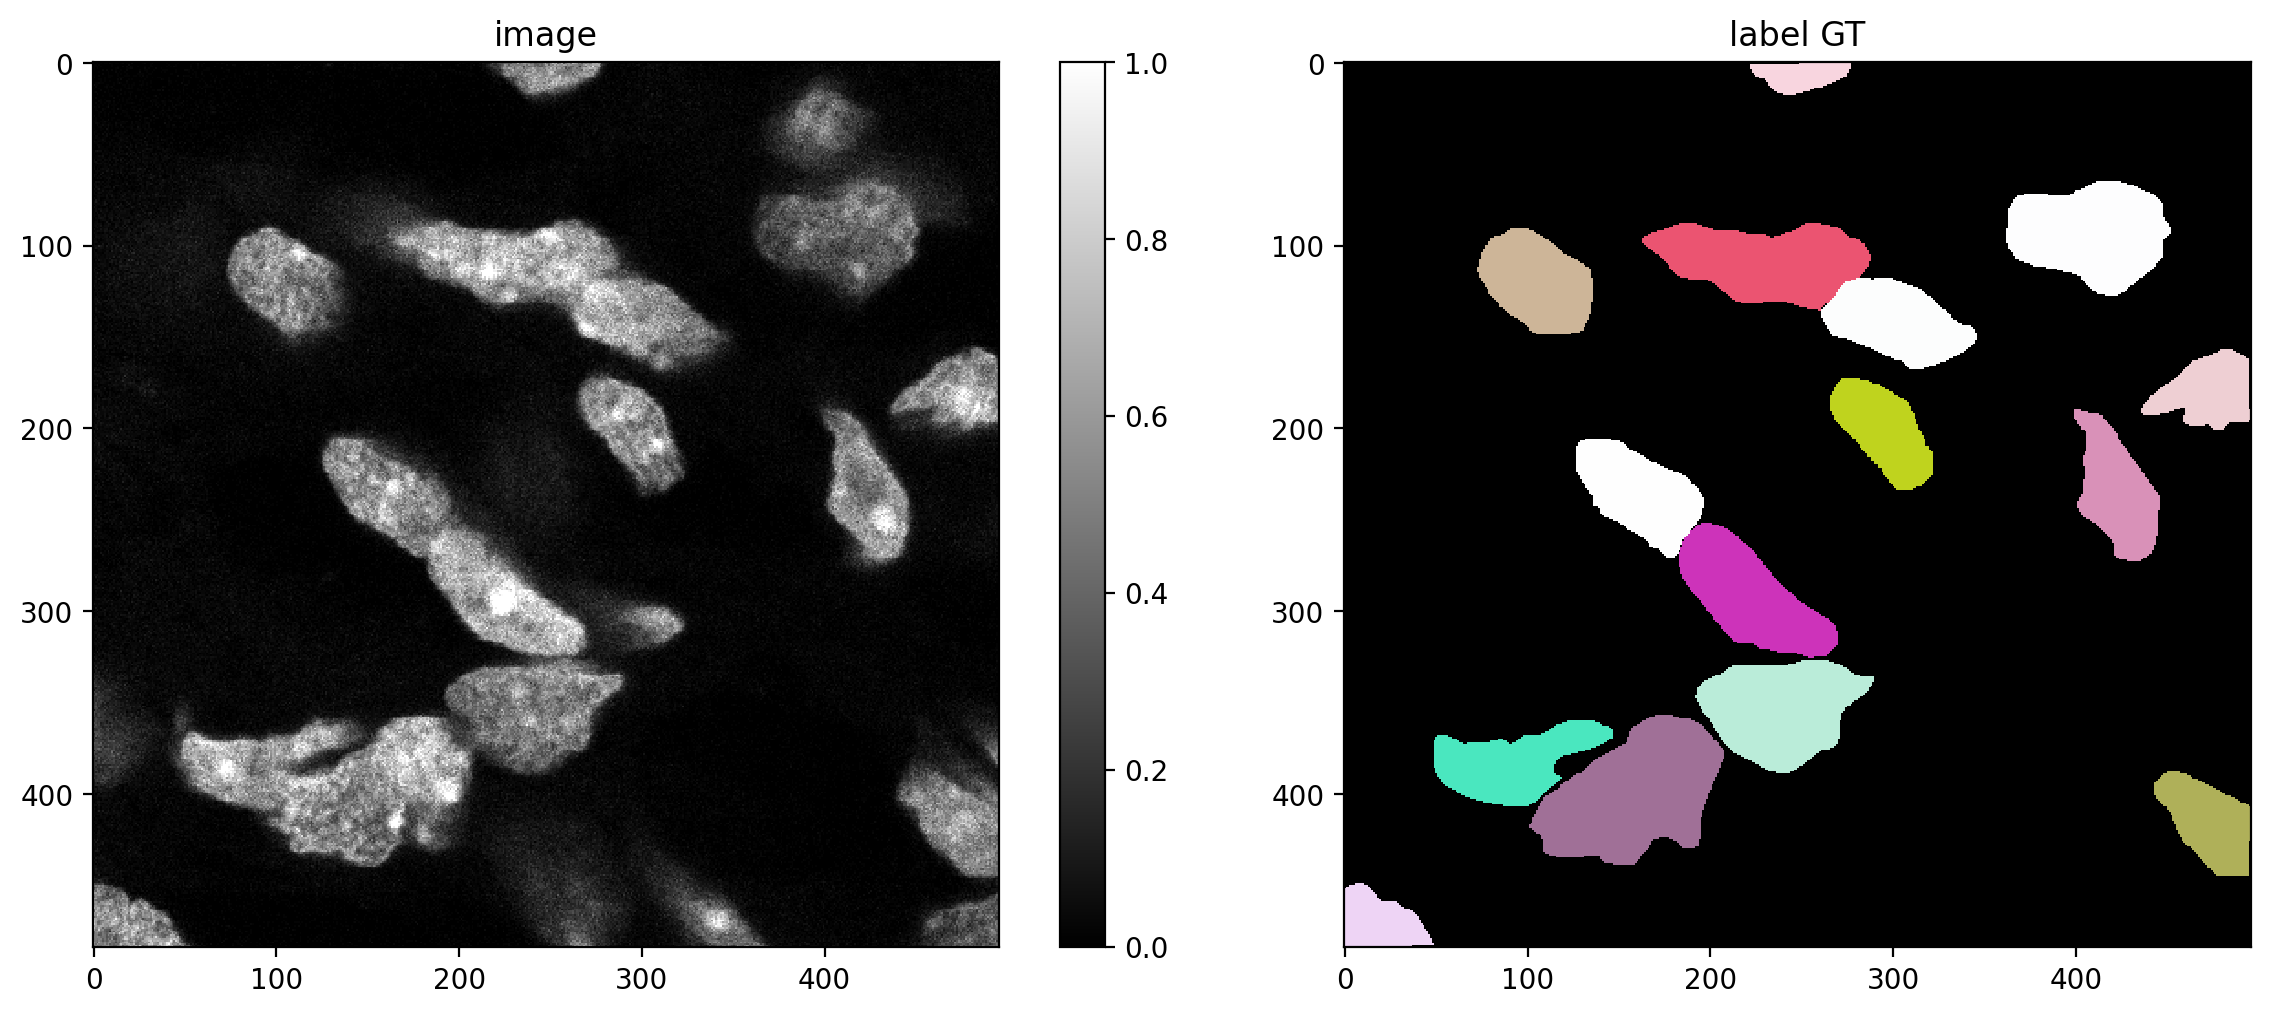

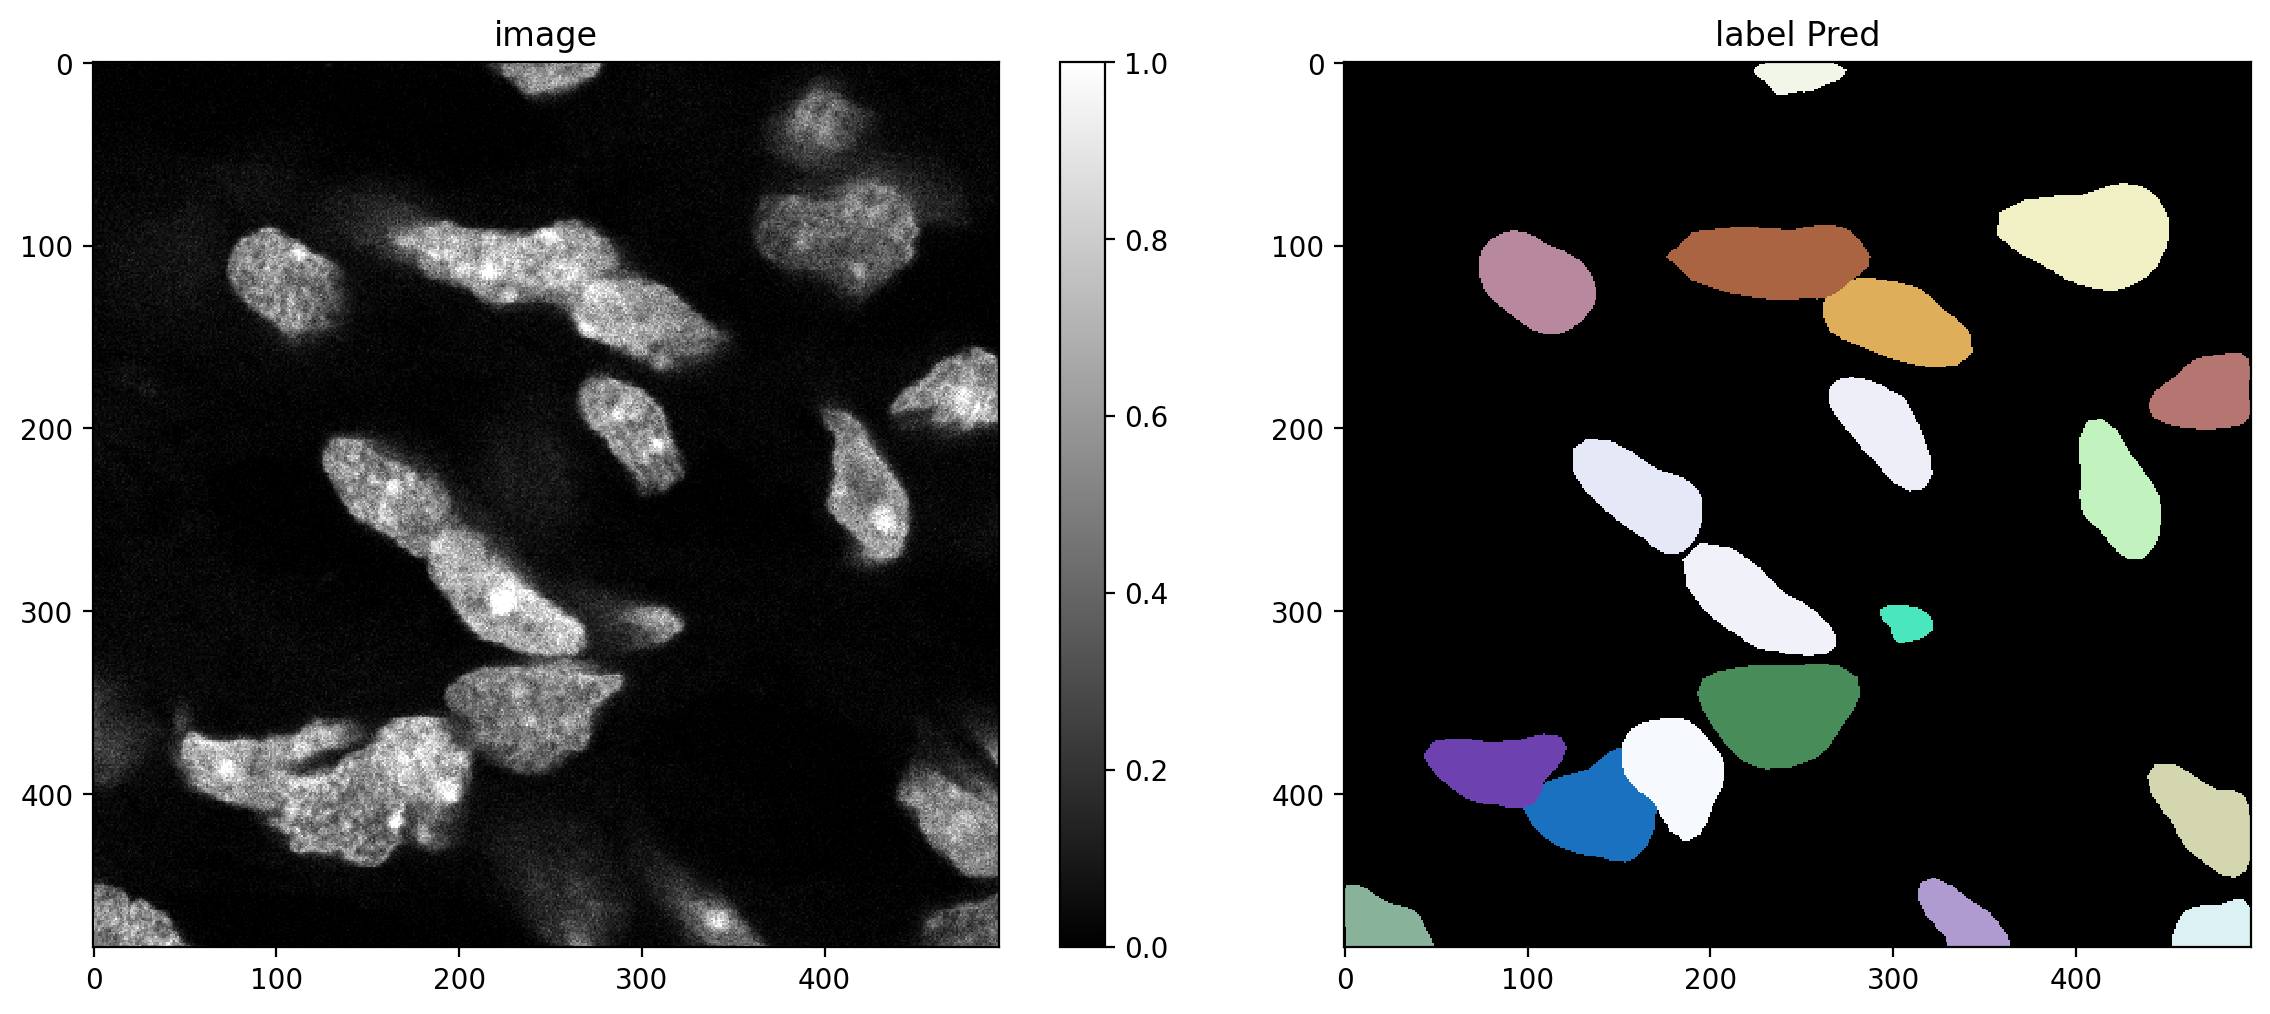

In [26]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

We can now observe how precision metrics and recall vary depending on tau threshold of IoU (intersection over union)

In [27]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:00<00:00, 22.30it/s]


For each value tau we compute the various precision values.

In [28]:
for t in taus:
    print("\n",t,":",stats[taus.index(t)])


 0.1 : DatasetMatching(criterion='iou', thresh=0.1, fp=23, tp=256, fn=35, precision=0.9175627240143369, recall=0.8797250859106529, accuracy=0.8152866242038217, f1=0.8982456140350877, n_true=291, n_pred=279, mean_true_score=0.7011846545635629, mean_matched_score=0.7970497440546751, panoptic_quality=0.7159464367649011, by_image=False)

 0.2 : DatasetMatching(criterion='iou', thresh=0.2, fp=23, tp=256, fn=35, precision=0.9175627240143369, recall=0.8797250859106529, accuracy=0.8152866242038217, f1=0.8982456140350877, n_true=291, n_pred=279, mean_true_score=0.7011846545635629, mean_matched_score=0.7970497440546751, panoptic_quality=0.7159464367649011, by_image=False)

 0.3 : DatasetMatching(criterion='iou', thresh=0.3, fp=23, tp=256, fn=35, precision=0.9175627240143369, recall=0.8797250859106529, accuracy=0.8152866242038217, f1=0.8982456140350877, n_true=291, n_pred=279, mean_true_score=0.7011846545635629, mean_matched_score=0.7970497440546751, panoptic_quality=0.7159464367649011, by_image

The higher tau, the lower the precision value and recall, as shown in the plots below.

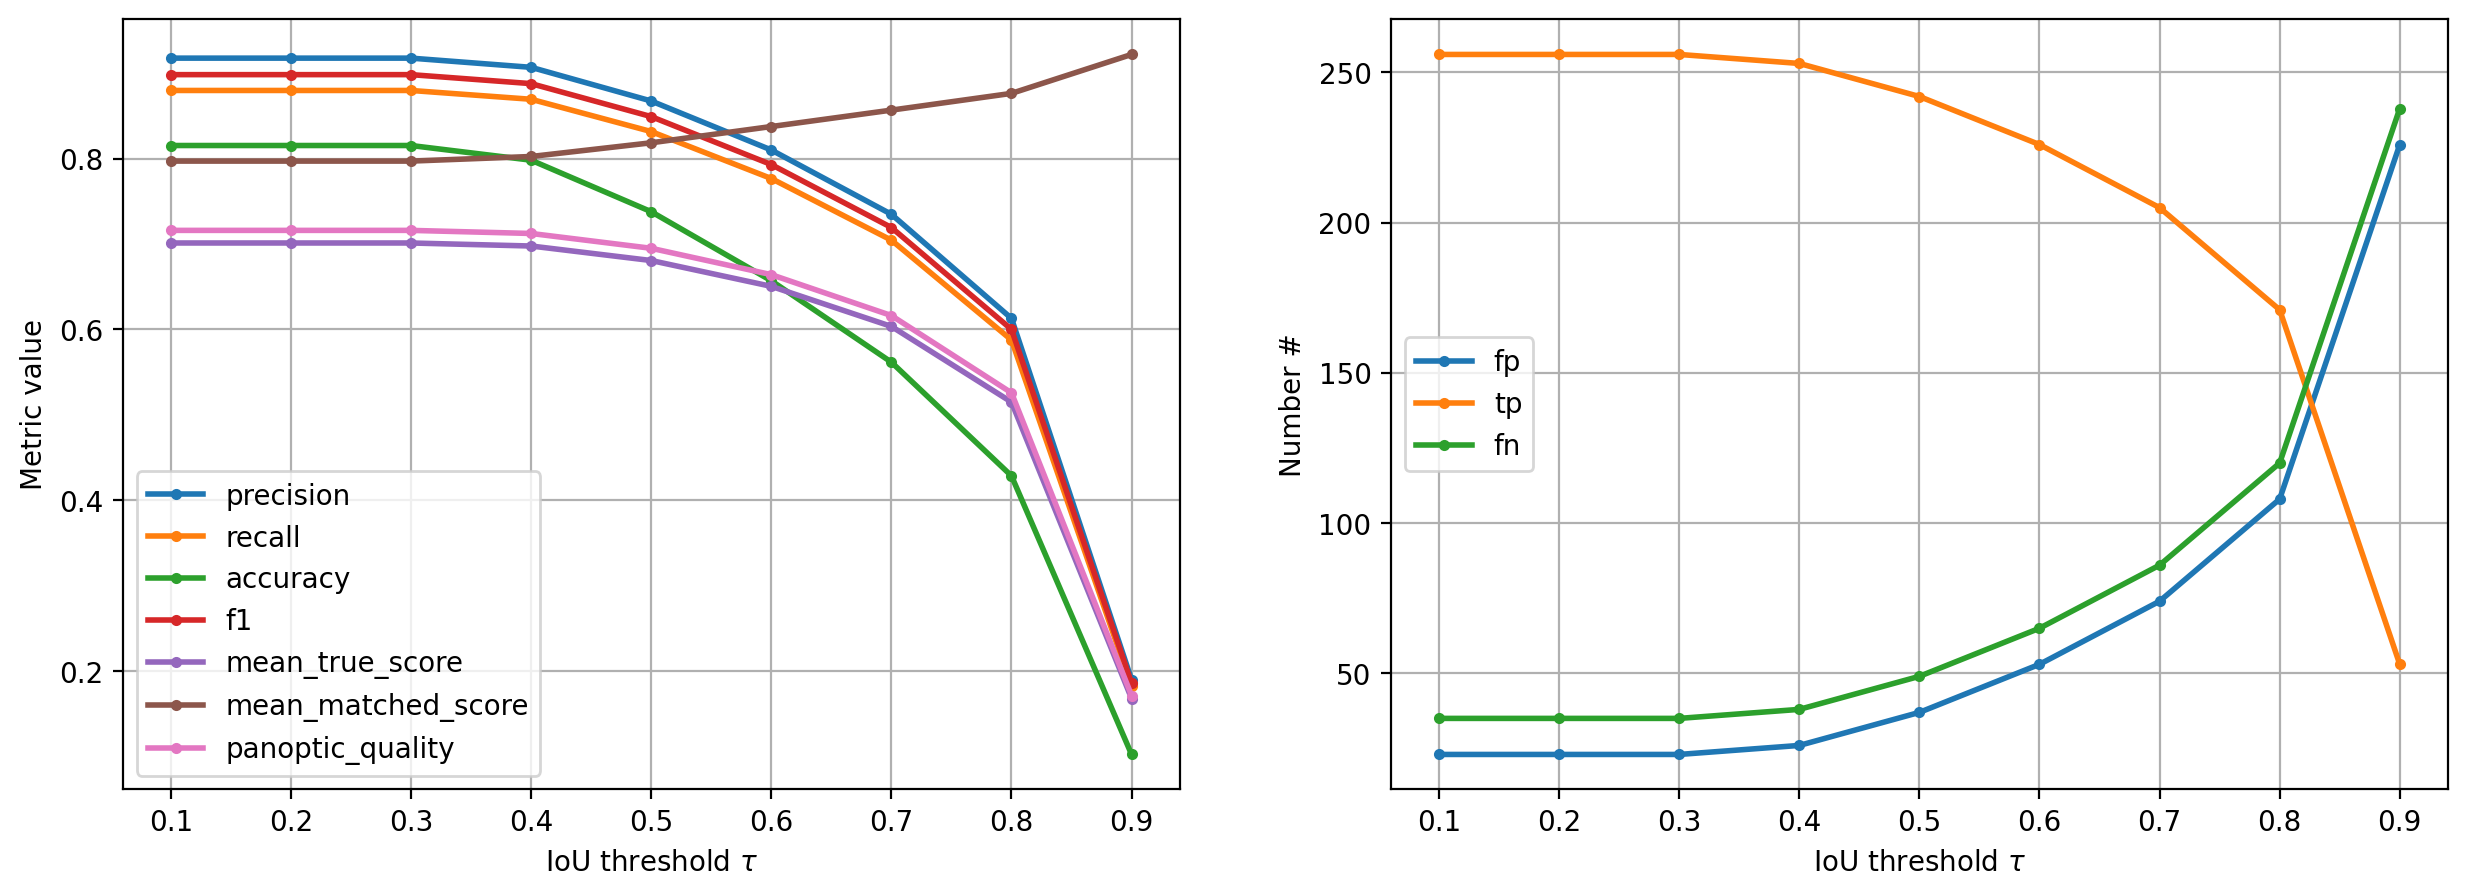

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();


Average precision value

In [30]:
np.mean([x.precision for x in stats])

0.7638391079251294